In [ ]:
pip install pydot

In [ ]:
pip install graphviz

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from typeguard import typechecked
from typing import Optional
from sklearn.metrics import roc_curve, auc

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load files

In [3]:
train_list_filenames=[]
train_list_labels=[]
dstpath='drive/My Drive/Proyect Final Vision/train'
test_df = pd.read_csv('drive/My Drive/Proyect Final Vision/test.txt', sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())
train_txt= open("drive/My Drive/Proyect Final Vision/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(dstpath, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)

                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0  drive/My Drive/Proyect Final Vision/train/ARDS...  negative
1  drive/My Drive/Proyect Final Vision/train/acut...  negative
2  drive/My Drive/Proyect Final Vision/train/acut...  negative
3  drive/My Drive/Proyect Final Vision/train/ards...  negative
4  drive/My Drive/Proyect Final Vision/train/pneu...  negative
negative    13793
positive     2158
Name: labels, dtype: int64


In [4]:
file_count = 2158
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

positive    2158
negative    2158
Name: labels, dtype: int64
4316


In [5]:
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)

# Create generators

In [6]:
def scalar(img):
    return img/255

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=scalar)

valid_datagen = ImageDataGenerator(preprocessing_function=scalar)

In [81]:
train_gen  = train_datagen.flow_from_dataframe(train_df,
                                                   x_col='filenames',
                                                   y_col='labels', 
                                                   target_size = (224,224),                                                                                                  
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 60,
                                                   color_mode='rgb',
                                                   shuffle=False)

Found 3884 validated image filenames belonging to 2 classes.


In [8]:
valid_gen = valid_datagen.flow_from_dataframe(valid_df,
                                                  x_col='filenames',
                                                  y_col='labels',
                                                  target_size = (224,224),                                                  
                                                  class_mode = 'categorical',
                                                  batch_size = 60,
                                                  color_mode='rgb',
                                                  shuffle=False)

Found 432 validated image filenames belonging to 2 classes.


In [10]:
nb_train_sample = train_df.shape[0] * 0.9
#nb_train_sample = 1165 * 0.9
nb_validation_sample = train_df.shape[0] - nb_train_sample
#nb_validation_sample = 1165 - nb_train_sample
nb_test_sample = valid_df.shape[0]
#nb_test_sample = 130
print(nb_train_sample)
print(nb_validation_sample)
print(nb_test_sample)

3495.6
388.4000000000001
432


In [11]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 2
    else:
        return num_samples // batch_size

# Define the model

In [ ]:
base_model = tf.keras.applications.NASNetMobile(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [51]:
for layer in base_model.layers[:-4]:
    layer.trainable= False

In [52]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2,activation='softmax'))
model.build((None,224,224,3))

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1056)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51744)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 51744)             206976    
_________________________________________________________________
dense (Dense)                (None, 256)               13246720  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_188 (Activation)  (None, 256)               0

In [76]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [77]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

In [ ]:
model_path = 'gdrive/My Drive/Proyect Final Vision/model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_path = model_path + 'NasNetModel.hdf5'

In [79]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 1,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint(filepath='gdrive/My Drive/Proyect Final Vision/model/NasNetMobile-model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

es = EarlyStopping(verbose=1, patience=4)

In [55]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

# Training

In [82]:
history=model.fit(train_gen,
                  validation_data=valid_gen,
                  batch_size=60,
                  epochs = 100,
                  verbose = 1,
                  callbacks=[lrd,es],
                  steps_per_epoch=get_steps(nb_train_sample, 60),
                  validation_steps=get_steps(nb_validation_sample, 60))

Epoch 1/100
60/60 [==============================] - 1564s 26s/step - loss: 0.0619 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9971 - val_loss: 0.2682 - val_accuracy: 0.9259 - val_precision: 0.9259 - val_recall: 0.9259 - val_auc: 0.9765
Epoch 2/100
60/60 [==============================] - 400s 7s/step - loss: 0.0584 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9972 - val_loss: 0.1888 - val_accuracy: 0.9514 - val_precision: 0.9514 - val_recall: 0.9514 - val_auc: 0.9868
Epoch 3/100
60/60 [==============================] - 317s 5s/step - loss: 0.0474 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9977 - val_loss: 0.2790 - val_accuracy: 0.9421 - val_precision: 0.9421 - val_recall: 0.9421 - val_auc: 0.9706

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/100
60/60 [==============================] - 319s 5s/step - loss: 0.0355 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.998

In [56]:
model.load_weights('drive/My Drive/Proyect Final Vision/model/modelNasNetMobile.hdf5')

In [83]:
model.save('drive/My Drive/Proyect Final Vision/model/NasNet-Model.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [12]:
loaded_model  = tf.keras.models.load_model('drive/My Drive/Proyect Final Vision/model/NasNet-Model.hdf5')

# Evaluate the model

In [14]:
acc=loaded_model.evaluate(valid_gen,batch_size=nb_test_sample, steps=get_steps(nb_test_sample, 60)-1, verbose=1)
msg='Model accuracy on test set: ' + str(acc)

8/8 [==============================] - 172s 23s/step - loss: 0.1879 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9845


# Confusion matrix

In [15]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

8/8 [==============================] - 38s 4s/step


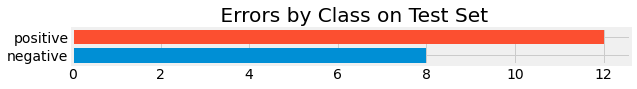

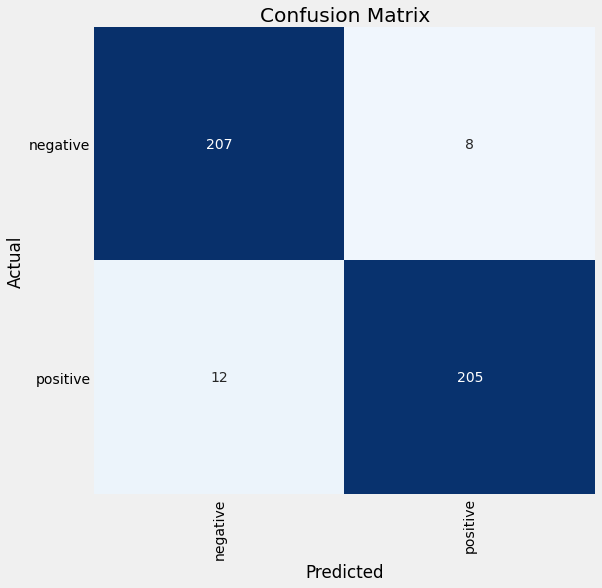

Classification Report:
----------------------
               precision    recall  f1-score   support

    negative       0.95      0.96      0.95       215
    positive       0.96      0.94      0.95       217

    accuracy                           0.95       432
   macro avg       0.95      0.95      0.95       432
weighted avg       0.95      0.95      0.95       432



In [16]:
print_code=0
preds=loaded_model.predict(valid_gen, batch_size=60, steps=get_steps(nb_validation_sample, 60), verbose=1)
print_info( valid_gen, preds, print_code, 'drive/My Drive/Proyect Final Vision/model/', 'covid' )

# Roc curve

In [18]:
valid_gen.reset()
preds = loaded_model.predict(valid_gen, batch_size=60, steps=get_steps(nb_validation_sample, 60), verbose=1)

8/8 [==============================] - 34s 4s/step


In [19]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(valid_gen.classes, preds[:,1])
auc_rf = auc(fpr_rf, tpr_rf)

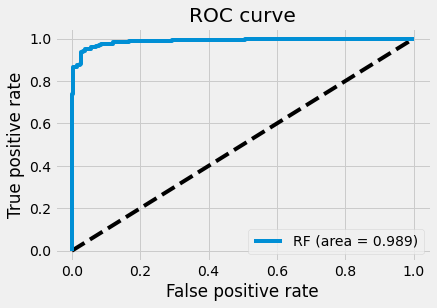

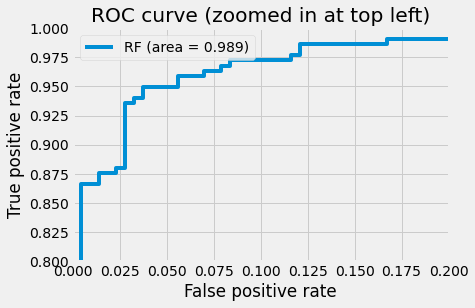

In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()